## CNN traffic sign classifier

In [1]:
#Dependencies

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import random
from torchvision import datasets, transforms
from torch.utils.data import random_split
import seaborn as sns
import pandas as pd
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit

import random
import textwrap

In [2]:
# train data path
train_data_path = "C:/Users/Aske/Desktop/DL project local/DATA_sign"

# Resize all images to e.g, 112x112
data_transforms = transforms.Compose([transforms.Resize([112, 112]),transforms.ToTensor()])

# Load the training data with the defined transformation
dataset = datasets.ImageFolder(root=train_data_path, transform=data_transforms)

# Get the labels from the dataset
labels = [label for _, label in dataset.samples]

# StratifiedShuffleSplit with 1 split and a 80-20 split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Get the indices for train and val sets
train_indices, val_indices = next(sss.split(np.zeros(len(labels)), labels))

# Create objects for train and val sets
train_data = torch.utils.data.Subset(dataset, train_indices)
val_data = torch.utils.data.Subset(dataset, val_indices)

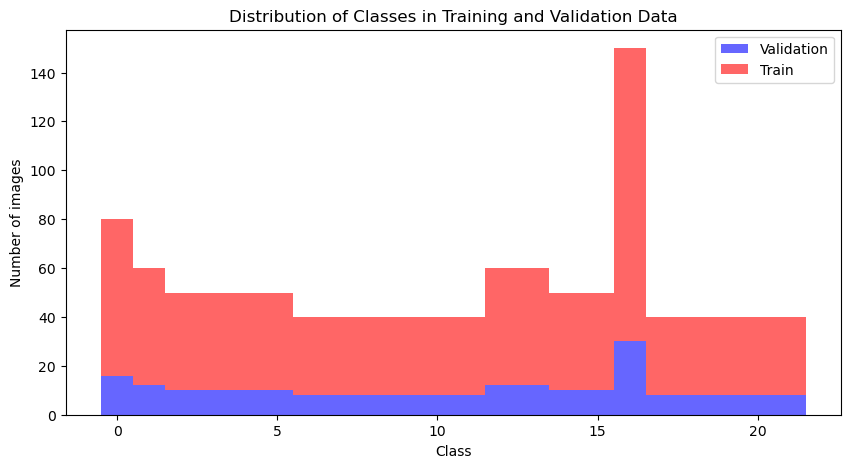

In [3]:
# Histogram of train and val

# Extract labels
train_labels = [label for _, label in train_data]
val_labels = [label for _, label in val_data]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot histogram of training data labels
ax.hist([val_labels, train_labels], bins=np.arange(len(dataset.classes)+1)-0.5, alpha=0.6, color=['b', 'red'], label=['Validation', 'Train'], histtype='barstacked')

# Set title, x-label, y-label, and legend
ax.set_title('Distribution of Classes in Training and Validation Data')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.legend(loc='upper right')

# Display the plot
plt.show()

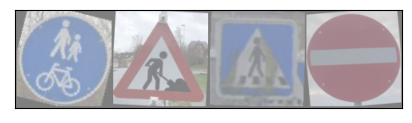

In [4]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img):
    plt.figure(figsize=(5, 10))  # Increase figure size
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])  
    plt.yticks([])  
    plt.show()

# Get some random training images
dataiter = iter(torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True))
images, labels = next(iter(dataiter))

# Show images with increased padding
imshow(torchvision.utils.make_grid(images, padding=2, nrow=4))

In [5]:
# Set the batch size
batch_size = 128 # change?

# Create a DataLoader for the training and validation set
train_loader = data.DataLoader(train_data, shuffle=True, batch_size = batch_size)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = batch_size)

#### **Model architecure**
A combination of convolutional, maxpooling and fully connected layers + dropout layers to prevent overfitting

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class TrafficClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TrafficClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = F.relu(self.conv5(x))
        x = self.maxpool3(x)

        x = x.view(x.shape[0], -1)
        x = self.dropout1(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

num_classes = 22 #
model = TrafficClassifier(num_classes)
print(model)

TrafficClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=22, bias=True)
)


In [7]:
# Test for proper syntax
testdata = torch.randn(1, 3, 112, 112)
testnet = TrafficClassifier(num_classes)
testnet.forward(testdata)

tensor([[ 0.0335,  0.0603,  0.0036, -0.0170,  0.0076, -0.0485, -0.0131, -0.0640,
          0.0035,  0.0045, -0.0548,  0.0728, -0.0057, -0.0557,  0.0662,  0.0015,
          0.0014,  0.0599,  0.0216, -0.0502,  0.0613,  0.0512]],
       grad_fn=<AddmmBackward0>)

In [8]:
# Overview of model structure
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
         MaxPool2d-2           [-1, 64, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]          73,856
         MaxPool2d-4          [-1, 128, 14, 14]               0
            Conv2d-5          [-1, 256, 14, 14]         295,168
            Conv2d-6          [-1, 256, 14, 14]         590,080
            Conv2d-7          [-1, 128, 14, 14]         295,040
         MaxPool2d-8            [-1, 128, 7, 7]               0
           Dropout-9                 [-1, 6272]               0
           Linear-10                  [-1, 512]       3,211,776
          Dropout-11                  [-1, 512]               0
           Linear-12                  [-1, 256]         131,328
           Linear-13                   [-1, 22]           5,654
Total params: 4,604,694
Trainable param

**Training setup**

In [9]:
# Learning and epochs
learning_rate = 0.001
epochs = 40

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# Print optimizer details
print("Optimizer details:")
print(optimizer)

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [11]:
# Calculate accuracy
def compute_accuracy(y_pred, y_true):
    predictions = torch.max(y_pred, dim=1)[1]
    corrects = (predictions == y_true).float().sum()
    accuracy = corrects / y_true.shape[0]
    return accuracy

In [12]:
# Function to perform training
def perform_training(model, loader, optimizer, loss_criterion):
    total_loss = 0
    total_acc = 0
    
    # training mode
    model.train()
    
    for (images, labels) in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(images)  
        loss = loss_criterion(y_pred, labels)  
        
        # Compute accuracy with the previous function
        acc = compute_accuracy(y_pred, labels)  
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update the total loss and accuracy
        total_loss += loss.item()
        total_acc += acc.item()
        
    return total_loss / len(loader), total_acc / len(loader)


In [13]:
def perform_evaluation(model, loader, loss_criterion):
    total_loss = 0
    total_acc = 0
    
    # evaluation mode
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # predictions
            y_pred = model(images)
            loss = loss_criterion(y_pred, labels)
            
            # accuracy
            acc = compute_accuracy(y_pred, labels)
            
            total_loss += loss.item()
            total_acc += acc.item()
    
    return total_loss / len(loader), total_acc / len(loader)

In [14]:
# Training loop

# Lists to save training and validation loss and accuracies
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training
    training_loss, training_accuracy = perform_training(model, train_loader, optimizer, criterion)

    # Validation
    validation_loss, validation_accuracy = perform_evaluation(model, val_loader, criterion)

    # Save losses and accuracies
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    # Print stats
    print(f"Training loss = {training_loss:.4f}, Train accuracy = {training_accuracy:.4f}")
    print(f"Validation loss = {validation_loss:.4f}, Validation accuracy = {validation_accuracy:.4f}")
    print("")

Epoch 1/40
Training loss = 3.0756, Train accuracy = 0.1071
Validation loss = 3.0844, Validation accuracy = 0.0695

Epoch 2/40
Training loss = 3.0826, Train accuracy = 0.0895
Validation loss = 3.0758, Validation accuracy = 0.1301

Epoch 3/40
Training loss = 3.0639, Train accuracy = 0.1250
Validation loss = 3.0333, Validation accuracy = 0.1311

Epoch 4/40
Training loss = 3.0370, Train accuracy = 0.1214
Validation loss = 3.0314, Validation accuracy = 0.1331

Epoch 5/40
Training loss = 2.9981, Train accuracy = 0.1383
Validation loss = 2.9772, Validation accuracy = 0.1301

Epoch 6/40
Training loss = 2.9141, Train accuracy = 0.1380
Validation loss = 2.8715, Validation accuracy = 0.1997

Epoch 7/40
Training loss = 2.7535, Train accuracy = 0.1986
Validation loss = 2.4170, Validation accuracy = 0.2279

Epoch 8/40
Training loss = 2.3033, Train accuracy = 0.2288
Validation loss = 2.1137, Validation accuracy = 0.2280

Epoch 9/40
Training loss = 2.0627, Train accuracy = 0.2790
Validation loss = 1.8

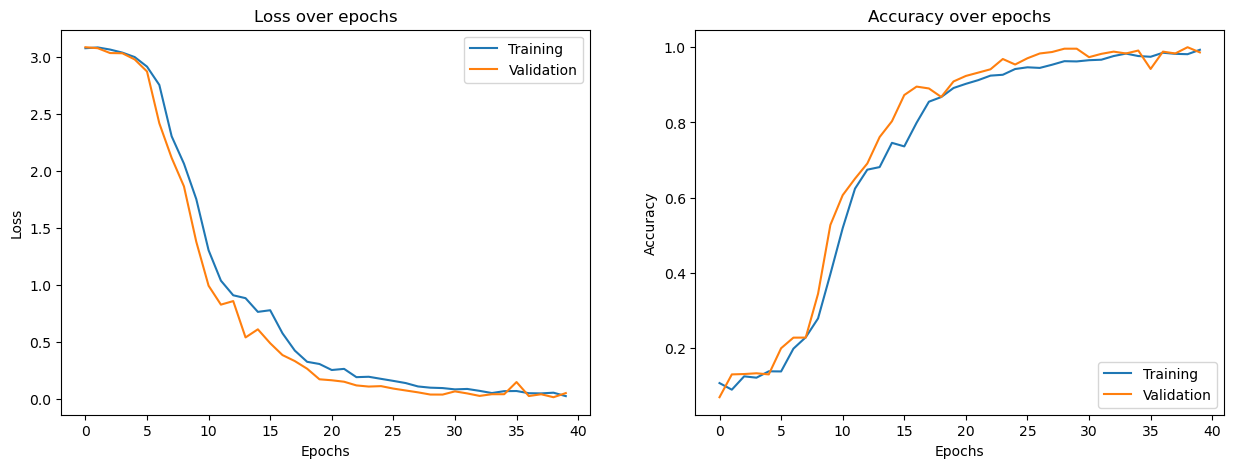

In [15]:
#Plot loss function and accuracy of train and validation data

# Create a figure with two subplots
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(15, 5))

# loss
loss_ax.plot(training_losses, label="Training")
loss_ax.plot(validation_losses, label="Validation")
loss_ax.set_title("Loss over epochs")
loss_ax.set_xlabel("Epochs")
loss_ax.set_ylabel("Loss")
loss_ax.legend(loc='upper right')

# accuracy
acc_ax.plot(training_accuracies, label="Training")
acc_ax.plot(validation_accuracies, label="Validation")
acc_ax.set_title("Accuracy over epochs")
acc_ax.set_xlabel("Epochs")
acc_ax.set_ylabel("Accuracy")
acc_ax.legend(loc='lower right')
plt.show()

**Test performance**

In [16]:
# Resize, same as before just for test data now
test_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [26]:
# Define path of test data
test_data_path = "C:/Users/Aske/Desktop/DL project local/TEST"

# Here the test data is loaded
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [29]:
# Classification on test data

# Set the model to evaluation mode
model.eval()

# counters
correct_predictions = 0
total_predictions = 0

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []


with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)

        # Get model outputs
        output = model(data)
        _, predictions = torch.max(output.data, 1)

        # Update counters
        total_predictions += target.size(0)
        correct_predictions += (predictions == target).sum().item()

        # Store true and predicted labels
        true_labels.extend(target.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print results
print(f"Correctly classified images: {correct_predictions}")
print(f"Incorrectly classified images: {total_predictions - correct_predictions}")
print(f"Final accuracy score: {accuracy:.6f}\n")

# Print classification report
print(classification_report(true_labels, predicted_labels))

Correctly classified images: 116
Incorrectly classified images: 2
Final accuracy score: 0.983051

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       1.00      1.00      1.00         6
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         5
          15       1.00      1.00    

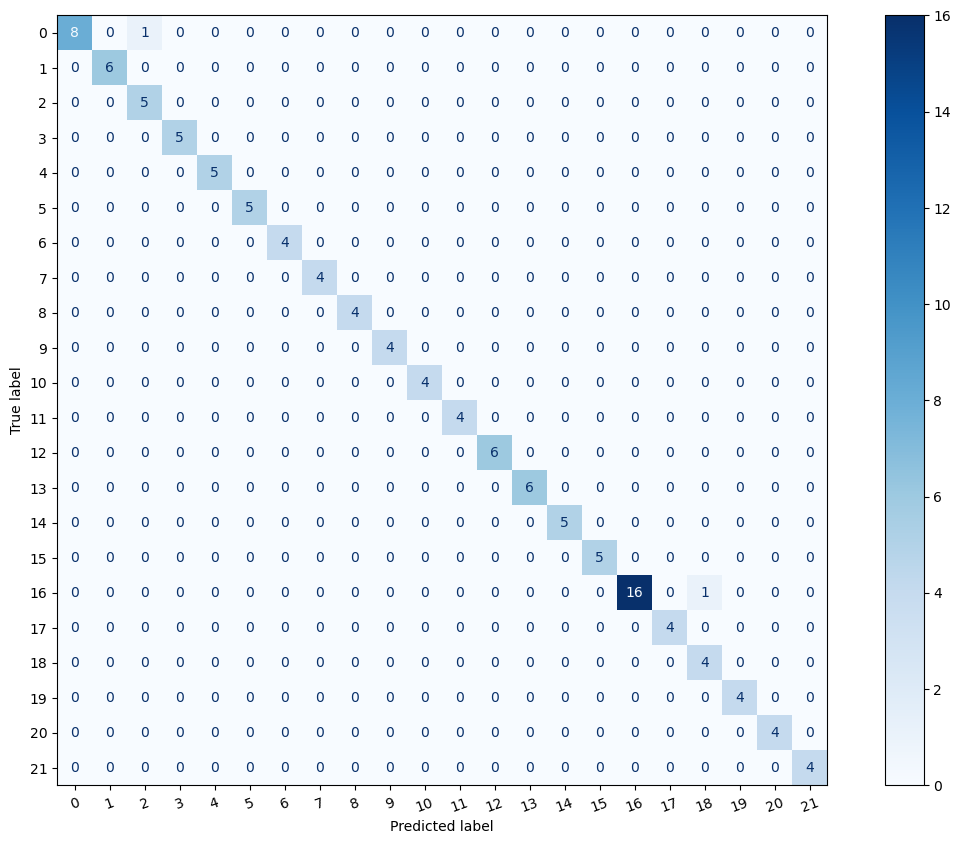

In [28]:
# Confusion matrix

def display_confusion_matrix(true_labels, predicted_labels, num_classes):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=range(num_classes))

    fig, ax = plt.subplots(figsize=(15, 10))
    cmd.plot(cmap='Blues', ax=ax, values_format='d')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=20)

display_confusion_matrix(true_labels, predicted_labels, num_classes=22)

In [20]:
# Print predicted and actual labels for a few images
print("Predicted labels: ", predicted_labels[50:60])
print("Actual labels: ", true_labels[50:60])

Predicted labels:  [9, 10, 10, 10, 10, 11, 11, 11, 11, 12]
Actual labels:  [9, 10, 10, 10, 10, 11, 11, 11, 11, 12]


In [21]:
# List of classes and descriptions maybe make some more metric for comparison
def print_class_descriptions(csv_file):
    df = pd.read_csv(csv_file, encoding='ISO-8859-1')
    for index, row in df.iterrows():
        print(f"Class: {row['ClassId']}, Description: {row['Name']}")

csv_file = "C:/Users/Aske/Desktop/DL project local/labels.csv"
print_class_descriptions(csv_file)

Class: 0, Description: Parkering forbudt
Class: 1, Description: Handikapparkering
Class: 2, Description:  Ubetinget vigepligt
Class: 3, Description: Fodgængerfelt
Class: 4, Description: Fartgrænse (60 km/t)
Class: 5, Description: Blind vej med stianlæg
Class: 6, Description: Fartgrænse (70 km/t)
Class: 7, Description: Indkørsel forbudt med ethvert køretøj
Class: 8, Description:  Påbudt passage
Class: 9, Description: Højresving forbudt
Class: 10, Description:  Standsning forbudt
Class: 11, Description: Indkørsel forbudt for motorkøretøjer
Class: 12, Description: Parkering
Class: 13, Description: Ensrettet
Class: 14, Description: Vejarbejde
Class: 15, Description: Ophør af område med fartdæmpning (40 km/t)
Class: 16, Description: Krydsende cyklister
Class: 17, Description: Venstresving
Class: 18, Description: Sammenfletning
Class: 19, Description: Cykel forbudt
Class: 20, Description: Fællessti
Class: 21, Description: Fartgrænse (40 km/t)


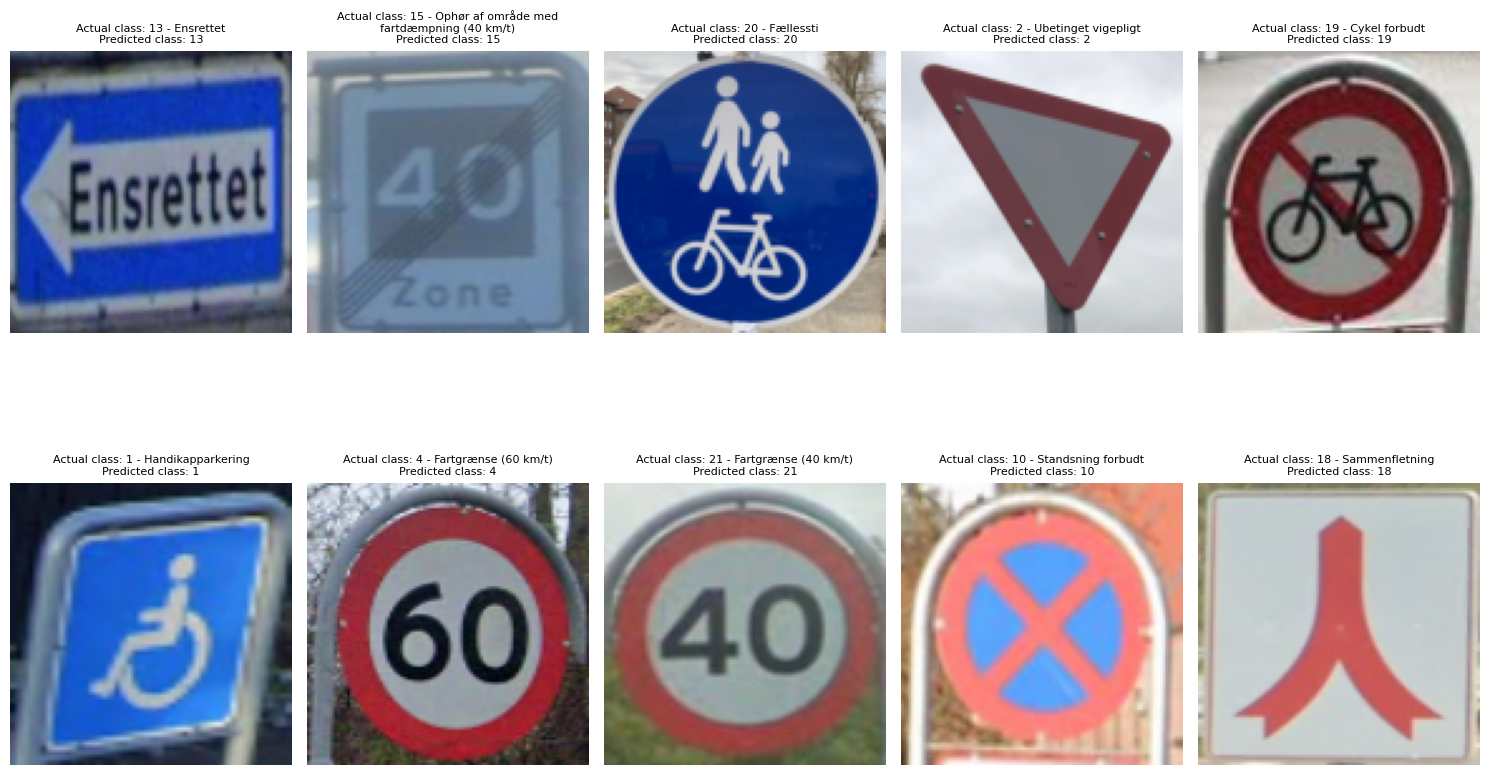

In [30]:
# Create a dictionary mapping class IDs to descriptions based on the CSV file above maybe make it smarter??
class_descriptions = {
    0: "Parkering forbudt",
    1: "Handikapparkering",
    2: "Ubetinget vigepligt",
    3: "Fodgængerfelt",
    4: "Fartgrænse (60 km/t)",
    5: "Blind vej med stianlæg",
    6: "Fartgrænse (70 km/t)",
    7: "Indkørsel forbudt med ethvert køretøj",
    8: "Påbudt passage",
    9: "Højresving forbudt",
    10: "Standsning forbudt",
    11: "Indkørsel forbudt for motorkøretøjer",
    12: "Parkering",
    13: "Ensrettet",
    14: "Vejarbejde",
    15: "Ophør af område med fartdæmpning (40 km/t)",
    16: "Krydsende cyklister",
    17: "Venstresving",
    18: "Sammenfletning",
    19: "Cykel forbudt",
    20: "Fællessti",
    21: "Fartgrænse (40 km/t)"
}

model.eval()
test_data_list = list(test_loader)
random_samples = random.sample(test_data_list, 10)
fig = plt.figure(figsize=(15, 10))

for i, (image, label) in enumerate(random_samples):
    image = image.to(device)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    actual_label = test_data.classes[label.item()]
    predicted_label = test_data.classes[predicted.item()]
    image = image.squeeze().cpu().numpy().transpose((1, 2, 0))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(image)
    
    # Get the class descriptions
    actual_description = class_descriptions[int(actual_label)]
    predicted_description = class_descriptions[int(predicted_label)]
    
    # Wrap the text if it's too long
    actual_description = textwrap.fill(actual_description, 30)
    predicted_description = textwrap.fill(predicted_description, 30)
    
    # Set the title with a smaller font size
    ax.set_title(f"Actual class: {actual_label} - {actual_description}\nPredicted class: {predicted_label}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()